<h2 align="center">📓 Notebook 1: Data Exploration, Preprocessing, and Baseline Model</h2>

## 📌 Project: AI-Powered Contract Document Classification  

### 🎯 Objective  
The goal of this notebook is to perform the initial exploratory data analysis (EDA), preprocess the raw text data, and build a simple baseline machine learning model.

---

### 🛠 Steps  

1. **Exploratory Data Analysis (EDA)**  
   - Load the dataset  
   - Analyze basic properties (class distribution, text length, etc.)  

2. **Text Preprocessing**  
   - Clean and standardize the raw text  
   - Prepare for feature extraction  

3. **Baseline Model**  
   - Use **TF-IDF + Logistic Regression**  
   - Serve as a performance benchmark  

4. **Evaluation**  
   - Apply standard classification metrics (accuracy, precision, recall, F1-score, etc.)  


## 1. Exploratory Data Analysis (EDA)

First, we'll load our synthetic dataset and perform a few checks to ensure it's structured as we expect.  
Our main goals are to:  
- Verify the **class balance**  
- Understand the **basic statistics** of our document text  


In [1]:
# Import necessary libraries for data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style
sns.set_style("whitegrid")

# --- 1.1 Load the Dataset ---
data_path = "../data/raw/contracts.csv"
df = pd.read_csv(data_path)

# --- 1.2 Initial Inspection ---
print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset Information:")
df.info()

First 5 rows of the dataset:


,text,category
0,The relationship of the parties is that of ind...,Employment
1,delivery schedule. Confidentiality obligations...,Vendor
2,Any amendments to this Agreement must be in wr...,Vendor
3,delivery schedule. Confidentiality obligations...,Vendor
4,Neither party may assign its rights or obligat...,Employment



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1000 non-null   object
 1   category  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


### 1.2 Check Class Distribution

It's critical to check if our dataset is balanced.  
An **imbalanced dataset** (where some categories have far more examples than others) can bias the model.  

Our data generation script was designed to create a **perfectly balanced dataset**, which we will now verify.  



Distribution of Contract Categories:


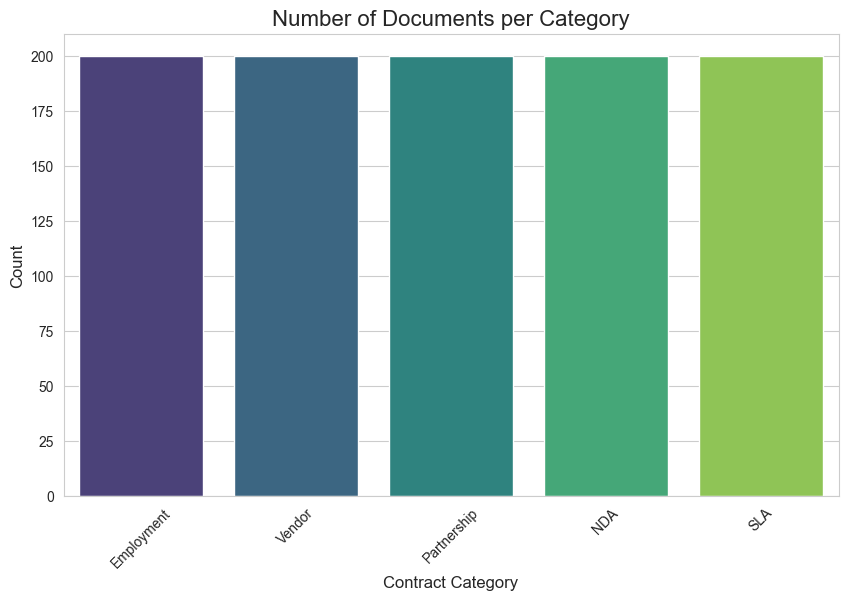

In [2]:
# --- Visualize Class Distribution ---
print("\nDistribution of Contract Categories:")
plt.figure(figsize=(10, 6))
sns.countplot(
    x='category', 
    data=df,
    hue='category',
    palette='viridis'
    )
plt.title('Number of Documents per Category', fontsize=16)
plt.xlabel('Contract Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

The bar chart confirms that our dataset is perfectly balanced, with exactly 200 documents for each of the five contract categories. This is the ideal scenario for a classification task as it prevents the model from developing a bias towards a majority class during training. We can therefore proceed without needing to apply corrective techniques like over-sampling or under-sampling.

### 1.3 Analyze Text Length

Next, let's analyze the **length of the documents**.  
This helps us understand the variance in our dataset and can be important for certain models that have **input length restrictions**.  

We'll:  
- Calculate the **word count** for each document  
- Plot the **distribution of document lengths**  


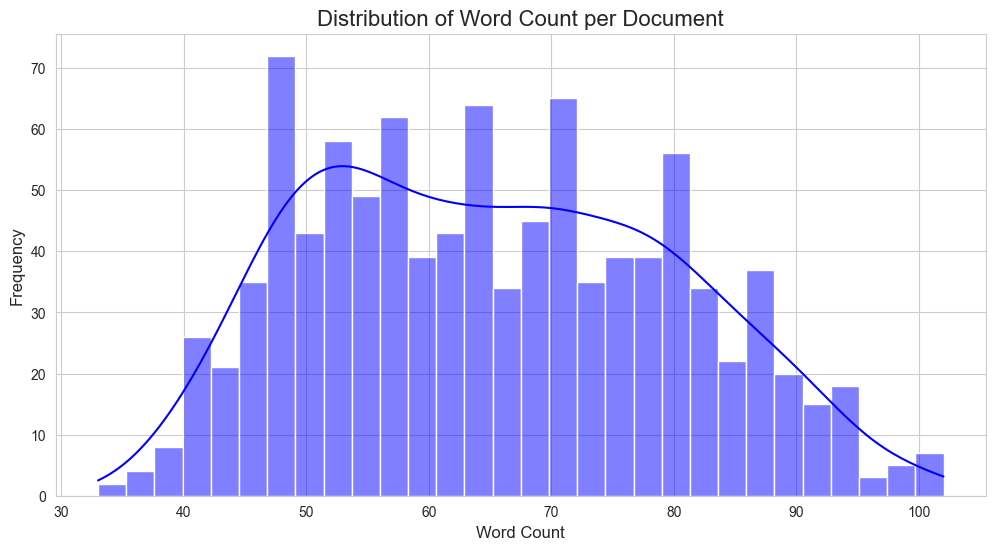


Word Count Statistics:
count    1000.000000
mean       65.209000
std        14.776931
min        33.000000
25%        53.000000
50%        64.000000
75%        77.000000
max       102.000000
Name: word_count, dtype: float64


In [3]:
# --- Calculate and Visualize Text Length ---
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Word Count per Document', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Display summary statistics for word count
print("\nWord Count Statistics:")
print(df['word_count'].describe())

The histogram and summary statistics show that document lengths follow a roughly normal distribution, with the average document containing about 65 words. The text lengths are consistent, with a maximum of only 102 words, which is well within the input limits for transformer models like BERT. This confirms we won't need to implement truncation or chunking strategies for this particular dataset

## 2. Text Preprocessing

Now that we understand our data, we'll move on to **cleaning the text**.  
We will create a single function `preprocess_text` that performs all the necessary steps:

1. **Convert text to lowercase**  
2. **Remove punctuation and numbers**  
3. **Tokenize the text into words**  
4. **Remove common English stop words**  

This function will prepare our text data for machine learning.  


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- Download NLTK resources ---
# We only need to run these download commands once.
# 'punkt' is for tokenization.
# 'stopwords' is for the list of common stop words.
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load the set of English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans and preprocesses a single text document.
    
    Args:
        text (str): The raw text of the document.
        
    Returns:
        str: The processed text, ready for feature extraction.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    # Using regex to keep only alphabetic characters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return " ".join(filtered_tokens)

[nltk_data] Downloading package punkt to /home/mr-rey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mr-rey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mr-rey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# --- Apply the preprocessing function ---
# Apply our function to the 'text' column to create a new 'processed_text' column.
df['processed_text'] = df['text'].apply(preprocess_text)

# --- Display the result ---
print("Original vs. Processed Text (First 5 Rows):")
display(df[['text', 'processed_text']].head())

Original vs. Processed Text (First 5 Rows):


,text,processed_text
0,The relationship of the parties is that of ind...,relationship parties independent contractors a...
1,delivery schedule. Confidentiality obligations...,delivery schedule confidentiality obligations ...
2,Any amendments to this Agreement must be in wr...,amendments agreement must writing signed parti...
3,delivery schedule. Confidentiality obligations...,delivery schedule confidentiality obligations ...
4,Neither party may assign its rights or obligat...,neither party may assign rights obligations ag...


The output confirms that our preprocessing function is working as expected. It has successfully converted the original text to lowercase, removed all punctuation, and stripped out common stop words (e.g., "the," "of," "is"). This process effectively reduces noise, ensuring that our model can focus on the most meaningful keywords that differentiate the contract types.

## 3. Feature Extraction with TF-IDF

Before we can train a model, we need to **convert our processed text into a numerical representation**.  
We will use the **Term Frequency-Inverse Document Frequency (TF-IDF)** vectorization technique.  

TF-IDF creates a matrix where:  
- Each **row** represents a document  
- Each **column** represents a unique word in our vocabulary  
- Each **cell value** is a score that reflects how important a word is to a document relative to the entire collection  

---

### Train-Test Split
First, we need to **split our data** into a training set and a testing set.  
This is a crucial step to ensure we can **evaluate our model's performance on unseen data**.  


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Split the Data ---
# We'll use an 80/20 split for training and testing data.
# 'X' is our feature (the text), and 'y' is our target (the category).
X = df['processed_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures the split has the same proportion of categories as the original dataset
)

# --- Initialize and Fit TF-IDF Vectorizer ---
# We will initialize the TfidfVectorizer. 
# It will learn the vocabulary only from the training data.
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit to the top 5000 features

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Only transform the test data using the already fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- Check the Results ---
print("Shape of the TF-IDF training matrix:", X_train_tfidf.shape)
print("Shape of the TF-IDF testing matrix:", X_test_tfidf.shape)

Shape of the TF-IDF training matrix: (800, 159)
Shape of the TF-IDF testing matrix: (200, 159)


## 4. Baseline Model: Training & Prediction

With our data **preprocessed and vectorized**, we can now train our first model.  
We will use **Logistic Regression**, a strong and interpretable baseline for text classification tasks.  

---

### Process Overview
1. **Initialize** the Logistic Regression model  
2. **Train** the model on our TF-IDF training data (`X_train_tfidf`, `y_train`)  
3. **Predict** on the unseen test data (`X_test_tfidf`)  


In [7]:
from sklearn.linear_model import LogisticRegression

# --- Initialize and Train the Model ---
# We'll use a random_state for reproducibility.
baseline_model = LogisticRegression(random_state=42, max_iter=1000)

print("Training the baseline Logistic Regression model...")
baseline_model.fit(X_train_tfidf, y_train)
print("Training complete.")

# --- Make Predictions on the Test Set ---
print("\nMaking predictions on the test set...")
y_pred = baseline_model.predict(X_test_tfidf)
print("Predictions made successfully.")

# Display the first 5 predictions
print("\nFirst 5 predictions:", y_pred[:5])

Training the baseline Logistic Regression model...
Training complete.

Making predictions on the test set...
Predictions made successfully.

First 5 predictions: ['Partnership' 'Employment' 'NDA' 'NDA' 'SLA']


## 5. Baseline Model Evaluation

Now that we have the model's predictions, we will evaluate its performance using several standard classification metrics.  
This will tell us how **accurate our baseline model** is and **where it might be making mistakes**.  

---

### Evaluation Metrics  

1. **Accuracy Score**  
   - The simplest metric, showing the overall percentage of correct predictions.  

2. **Classification Report**  
   - Provides detailed metrics: **precision**, **recall**, and **F1-score** for each category.  
   - The **F1-score** is especially important in balanced classification tasks.  

3. **Confusion Matrix**  
   - A visual grid showing which categories are being confused with others.  


Overall Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Employment       1.00      1.00      1.00        40
         NDA       1.00      1.00      1.00        40
 Partnership       1.00      1.00      1.00        40
         SLA       1.00      1.00      1.00        40
      Vendor       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:


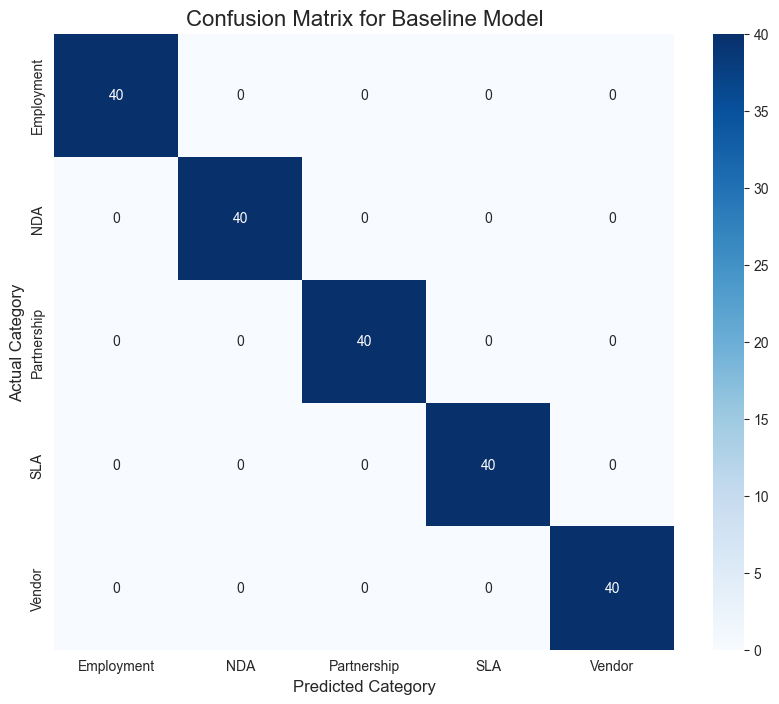

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Calculate Accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# --- Display Classification Report ---
# This report provides a detailed breakdown of the model's performance per category.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Visualize the Confusion Matrix ---
# The confusion matrix helps us see where the model is getting confused.
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=baseline_model.classes_, yticklabels=baseline_model.classes_)
plt.title('Confusion Matrix for Baseline Model', fontsize=16)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.show()

---
#### 6. Interpretation of Baseline Results

The evaluation metrics show that our baseline model, a Logistic Regression classifier with TF-IDF features, achieved a **perfect accuracy of 100%** on the unseen test data. The classification report and confusion matrix confirm this, with F1-scores of 1.0 for every category and zero misclassifications.

This perfect performance is a direct result of the **simplicity of our synthetic dataset**. By design, each contract category was generated with a unique set of "signal" keywords that do not overlap with other categories. This created a linearly separable problem, which is the ideal scenario for a model like Logistic Regression.

While the model learned the patterns perfectly, this is not classic **overfitting**, as performance on the test set was flawless. Rather, it highlights that our test data, having been generated by the same simple rules as our training data, did not pose a significant generalization challenge. Nonetheless, this result is highly valuable as it establishes a **strong performance baseline**, confirming that our end-to-end pipeline is working correctly and that a more advanced model must also achieve this level of accuracy to be considered a better alternative.